# Movie Genre Predictor

Importing Libraries

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize 
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM,Dropout,Activation,Bidirectional,Embedding,Dense,Flatten,GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from gensim.models import Word2Vec, KeyedVectors
import tensorflow_hub as hub
from tensorflow.keras.regularizers import l2

In [ ]:
%tensorflow_version 2.x

Tensorflow Version is 2.3

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
tf.__version__

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'2.6.0'

Now Reading the data in CSV format through Pandas

In [ ]:
movies=pd.read_csv('/content/gdrive/MyDrive/wiki_movie_plots_deduped.csv')
# movies=pd.read_csv('wiki_movie_plots_deduped.csv')
movies.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


# Organizing Genre colunm for target Values


Now we are only predicting horror,drama,comedy and action so filtering them out

In [ ]:
MainGenres=['drama','comedy','action','horror']
movies=movies[movies['Genre'].isin(MainGenres)]
len(movies)

12608

In [ ]:
movies=movies.reset_index()
movies.head(5)

,index,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...
1,14,1907,How Brown Saw the Baseball Game,American,Unknown,Unknown,comedy,https://en.wikipedia.org/wiki/How_Brown_Saw_th...,Before heading out to a baseball game at a nea...
2,15,1907,Laughing Gas,American,Edwin Stanton Porter,"Bertha Regustus, Edward Boulden",comedy,https://en.wikipedia.org/wiki/Laughing_Gas_(fi...,The plot is that of a black woman going to the...
3,16,1908,The Adventures of Dollie,American,D. W. Griffith,"Arthur V. Johnson, Linda Arvidson",drama,https://en.wikipedia.org/wiki/The_Adventures_o...,On a beautiful summer day a father and mother ...
4,17,1908,The Black Viper,American,D. W. Griffith,D. W. Griffith,drama,https://en.wikipedia.org/wiki/The_Black_Viper,A thug accosts a girl as she leaves her workpl...


Now assigning id's to our genres according to GenreCoreected colunm

In [ ]:
movies['GenreID']=movies['Genre'].apply(lambda x:MainGenres.index(x))
movies.head(10)

,index,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,GenreID
0,7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...,1
1,14,1907,How Brown Saw the Baseball Game,American,Unknown,Unknown,comedy,https://en.wikipedia.org/wiki/How_Brown_Saw_th...,Before heading out to a baseball game at a nea...,1
2,15,1907,Laughing Gas,American,Edwin Stanton Porter,"Bertha Regustus, Edward Boulden",comedy,https://en.wikipedia.org/wiki/Laughing_Gas_(fi...,The plot is that of a black woman going to the...,1
3,16,1908,The Adventures of Dollie,American,D. W. Griffith,"Arthur V. Johnson, Linda Arvidson",drama,https://en.wikipedia.org/wiki/The_Adventures_o...,On a beautiful summer day a father and mother ...,0
4,17,1908,The Black Viper,American,D. W. Griffith,D. W. Griffith,drama,https://en.wikipedia.org/wiki/The_Black_Viper,A thug accosts a girl as she leaves her workpl...,0
5,18,1908,A Calamitous Elopement,American,D.W. Griffith,"Harry Solter, Linda Arvidson",comedy,https://en.wikipedia.org/wiki/A_Calamitous_Elo...,A young couple decides to elope after being ca...,1
6,20,1908,A Christmas Carol,American,Unknown,Tom Ricketts,drama,https://en.wikipedia.org/wiki/A_Christmas_Caro...,No prints of the first American film adaptatio...,0
7,22,1909,At the Altar,American,D. W. Griffith,Marion Leonard,drama,https://en.wikipedia.org/wiki/At_the_Altar,A rejected admirer sets up a trap to kill his ...,0
8,23,1909,A Drunkard's Reformation,American,D. W. Griffith,Arthur V. Johnson,drama,https://en.wikipedia.org/wiki/A_Drunkard%27s_R...,"John Wharton, the husband of a true and trusti...",0
9,24,1909,The Golden Louis,American,D. W. Griffith,NaN,drama,https://en.wikipedia.org/wiki/The_Golden_Louis,An old woman sends a girl begging in the stree...,0


Now Checking Individual Genre Record

In [ ]:
no_drama=movies['Genre'].str.contains('drama').sum()
no_comedy=movies['Genre'].str.contains('comedy').sum()
no_horror=movies['Genre'].str.contains('horror').sum()
no_action=movies['Genre'].str.contains('action').sum()
print("Number of Drama movies:",no_drama)
print("Number of Comedy movies:",no_comedy)
print("Number of Horror movies:",no_horror)
print("Number of Action movies:",no_action)

Number of Drama movies: 5964
Number of Comedy movies: 4379
Number of Horror movies: 1167
Number of Action movies: 1098


Showing Values in Bar chart

[Text(0.5, 0, 'Genre'), Text(0.5, 1.0, 'Genre Counnt')]

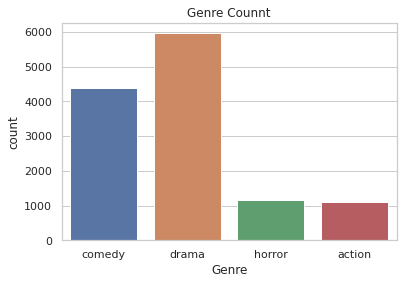

In [ ]:
import seaborn as sns
sns.set(style='whitegrid')
figsize=(18, 6)
ax=sns.countplot(x=movies['Genre'], data=movies)
ax.set(xlabel='Genre',title="Genre Counnt")

# Plot Summaries Pre-Processing

In [ ]:
import random
synNumber=random.randint(1,1000)
print(movies['Title'].loc[synNumber])
print(movies['Genre'].loc[synNumber])
print(movies['Plot'].loc[synNumber])

Enoch Arden
drama
Based on a summary in a film magazine,[2] Enoch, Annie, and Walter grow up as friends. Later, Annie decides to marry Enoch, but Walter, though bitter about the decision, remains their friend. Enoch and Annie have two children. Then business takes Enoch on a sailing voyage, which he states will take less than one year, and he asks Walter to look over his family while he is gone. Enoch does not return, and Walter dutifully cares after Enoch's wife and children. After ten years word comes of a wreck seen in the Pacific, and everyone believes Enoch has died. Walter and Annie then marry. One night a stranger comes to the house and through a window sees Walter, Annie, and the children happy. The stranger, who is Enoch, finds an old woman who tells him what happened. Enoch tells her to keep his secret, and then leaves. He later dies with a smile on his face.


In [ ]:
def  clean_text(df, text_field, new_text_field_name):
    df[new_text_field_name] = df[text_field].str.lower()
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    # remove numbers
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    
    return df

In [ ]:
data_clean = clean_text(movies, 'Plot', 'Plot_clean')
data_clean.head()

,index,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,GenreID,Plot_clean
0,7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...,1,the film is about a family who move to the sub...
1,14,1907,How Brown Saw the Baseball Game,American,Unknown,Unknown,comedy,https://en.wikipedia.org/wiki/How_Brown_Saw_th...,Before heading out to a baseball game at a nea...,1,before heading out to a baseball game at a nea...
2,15,1907,Laughing Gas,American,Edwin Stanton Porter,"Bertha Regustus, Edward Boulden",comedy,https://en.wikipedia.org/wiki/Laughing_Gas_(fi...,The plot is that of a black woman going to the...,1,the plot is that of a black woman going to the...
3,16,1908,The Adventures of Dollie,American,D. W. Griffith,"Arthur V. Johnson, Linda Arvidson",drama,https://en.wikipedia.org/wiki/The_Adventures_o...,On a beautiful summer day a father and mother ...,0,on a beautiful summer day a father and mother ...
4,17,1908,The Black Viper,American,D. W. Griffith,D. W. Griffith,drama,https://en.wikipedia.org/wiki/The_Black_Viper,A thug accosts a girl as she leaves her workpl...,0,a thug accosts a girl as she leaves her workpl...


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# plots=data_clean['Plot_clean'].values

In [ ]:
# vec=[word_tokenize(plot)for plot in plots]

In [ ]:
# modelvec=Word2Vec(vec,min_count=1)

In [ ]:
# word_embeddings=KeyedVectors.load_word2vec_format('/content/gdrive/MyDrive/GoogleNews-vectors-negative300.bin',binary=True)

In [ ]:
data_clean = data_clean.sample(frac=1).reset_index(drop=True)

In [ ]:
# stemmer = PorterStemmer()
# def stem_words(text):
#     return " ".join([stemmer.stem(word) for word in text.split()])

# data_clean["Plot_clean"] = data_clean["Plot_clean"].apply(lambda text: stem_words(text))
data_clean.head()

,index,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,GenreID,Plot_clean
0,32501,2011,Vasthad,Telugu,Rajamithran,"Aadhi, Meera Nandan",drama,https://en.wikipedia.org/wiki/Ayyanar_(film),Prabha (Aadhi Pinisetty) is the eldest son of ...,0,prabha aadhi pinisetty is the eldest son of th...
1,48,1912,Petticoat Camp,American,Unknown,"William Garwood, Florence La Badie",comedy,https://en.wikipedia.org/wiki/Petticoat_Camp,"Only lasting 15 minutes, it is a light-hearted...",1,only lasting minutes it is a lighthearted com...
2,15091,2006,Talladega Nights: The Ballad of Ricky Bobby,American,Adam McKay,"Will Ferrell, John C. Reilly, Sacha Baron Cohen",comedy,https://en.wikipedia.org/wiki/Talladega_Nights...,Ricky Bobby is a man who grew up dreaming of g...,1,ricky bobby is a man who grew up dreaming of g...
3,12831,1996,Skin & Bone,American,Everett Lewis,J. Wyatt,drama,https://en.wikipedia.org/wiki/Skin_%26_Bone_(f...,Skin & Bone is an episodic account of three Lo...,0,skin bone is an episodic account of three los...
4,2870,1940,The Man I Married,American,Irving Pichel,"Joan Bennett, Francis Lederer",drama,https://en.wikipedia.org/wiki/The_Man_I_Married,"A successful American woman, art critic Carol ...",0,a successful american woman art critic carol c...


In [ ]:
data_clean.to_csv('clean_data.csv')

In [ ]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(w) for w in text.split()])

In [ ]:
nltk.download('wordnet')
data_clean["Plot_clean"] = data_clean["Plot_clean"].apply(lambda text: lemmatize_text(text))
data_clean.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,index,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,GenreID,Plot_clean
0,32501,2011,Vasthad,Telugu,Rajamithran,"Aadhi, Meera Nandan",drama,https://en.wikipedia.org/wiki/Ayyanar_(film),Prabha (Aadhi Pinisetty) is the eldest son of ...,0,prabha aadhi pinisetty is the eldest son of th...
1,48,1912,Petticoat Camp,American,Unknown,"William Garwood, Florence La Badie",comedy,https://en.wikipedia.org/wiki/Petticoat_Camp,"Only lasting 15 minutes, it is a light-hearted...",1,only lasting minute it is a lighthearted comed...
2,15091,2006,Talladega Nights: The Ballad of Ricky Bobby,American,Adam McKay,"Will Ferrell, John C. Reilly, Sacha Baron Cohen",comedy,https://en.wikipedia.org/wiki/Talladega_Nights...,Ricky Bobby is a man who grew up dreaming of g...,1,ricky bobby is a man who grew up dreaming of g...
3,12831,1996,Skin & Bone,American,Everett Lewis,J. Wyatt,drama,https://en.wikipedia.org/wiki/Skin_%26_Bone_(f...,Skin & Bone is an episodic account of three Lo...,0,skin bone is an episodic account of three los ...
4,2870,1940,The Man I Married,American,Irving Pichel,"Joan Bennett, Francis Lederer",drama,https://en.wikipedia.org/wiki/The_Man_I_Married,"A successful American woman, art critic Carol ...",0,a successful american woman art critic carol c...


In [ ]:
data_clean['Plot_clean'] = data_clean['Plot_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
data_clean.head()

,index,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,GenreID,Plot_clean
0,32501,2011,Vasthad,Telugu,Rajamithran,"Aadhi, Meera Nandan",drama,https://en.wikipedia.org/wiki/Ayyanar_(film),Prabha (Aadhi Pinisetty) is the eldest son of ...,0,prabha aadhi pinisetty eldest son family doe n...
1,48,1912,Petticoat Camp,American,Unknown,"William Garwood, Florence La Badie",comedy,https://en.wikipedia.org/wiki/Petticoat_Camp,"Only lasting 15 minutes, it is a light-hearted...",1,lasting minute lighthearted comedy battle sex ...
2,15091,2006,Talladega Nights: The Ballad of Ricky Bobby,American,Adam McKay,"Will Ferrell, John C. Reilly, Sacha Baron Cohen",comedy,https://en.wikipedia.org/wiki/Talladega_Nights...,Ricky Bobby is a man who grew up dreaming of g...,1,ricky bobby man grew dreaming going fast worki...
3,12831,1996,Skin & Bone,American,Everett Lewis,J. Wyatt,drama,https://en.wikipedia.org/wiki/Skin_%26_Bone_(f...,Skin & Bone is an episodic account of three Lo...,0,skin bone episodic account three los angelesar...
4,2870,1940,The Man I Married,American,Irving Pichel,"Joan Bennett, Francis Lederer",drama,https://en.wikipedia.org/wiki/The_Man_I_Married,"A successful American woman, art critic Carol ...",0,successful american woman art critic carol cab...


Tokenizing and creating and padding the sequences

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts((list(data_clean['Plot_clean'])))
sequences=tokenizer.texts_to_sequences((list(data_clean['Plot_clean'])))
word_index=tokenizer.word_index
print("unique tokens:",len(word_index))
max_len=np.max([len(sequence) for sequence in sequences])
print("Max length:",max_len)
data = pad_sequences(sequences, maxlen=max_len)
print("Shape of data tensor:",data.shape)

unique tokens: 114645
Max length: 1488
Shape of data tensor: (12608, 1488)


Making Target labels to Categorical

In [ ]:
labels=np.asarray(movies['GenreID'])
labels=to_categorical(labels,num_classes=4)
print('Label:',labels.shape)
labels

Label: (12608, 4)


array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [ ]:
# embedding_dim=300
# total_words=len(word_index)+1
# skipped_words=0
# embedding_vector=None
# embedding_matrix=np.zeros((total_words,embedding_dim))
# for word,index in tokenizer.word_index.items():
#     try:
#         embedding_vector=wordembeddings[word]
#     except:
#         skipped_words-skipped_words+1
#         pass
#     if embedding_vector is not None:
#         embedding_matrix[index]=embedding_vector
# print("Embeddings Matrix Shape :",embedding_matrix.shape)

In [ ]:
# Embedding_layer=Embedding(total_words,embedding_dim,weights=[embedding_matrix],input_length=max_len,trainable=False)

# Creating a Model

In [ ]:
#splitting the data for training testing and validation
# training_samples=11000
# validation_samples=3000
# X_train=data[:training_samples]
# y_train=labels[:training_samples]
# X_val=data[training_samples:training_samples+validation_samples]
# y_val=labels[training_samples:training_samples+validation_samples]
X_train,X_val,y_train,y_val=train_test_split(data,labels,test_size=0.15,random_state=42)
# shuffle_index=np.random.permutation(len(X_train))
# X_train,y_train=X_train[shuffle_index],y_train[shuffle_index]

In [ ]:
embedding_dim=250
model=Sequential()
model.add(Embedding(input_dim=len(word_index)+1,output_dim=embedding_dim,input_length=max_len))
model.add(Dropout(0.2))
# model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
# model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64,kernel_regularizer=l2(0.0001),return_sequences=True)))
model.add(Dropout(0.4))
model.add(Flatten())
# model.add(LSTM(64,kernel_regularizer=l2(0.0001),return_sequences=True))
# model.add(Dropout(0.4))
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.6))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.6))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-5),metrics=['categorical_accuracy'])
model.summary()
# 32,kernel_regularizer=l2(0.001),input_shape=(X_train.shape[1:]),activation='tanh'

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 1488, 250)         28661500  
_________________________________________________________________
dropout_25 (Dropout)         (None, 1488, 250)         0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 1488, 128)         161280    
_________________________________________________________________
dropout_26 (Dropout)         (None, 1488, 128)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 190464)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 761860    
Total params: 29,584,640
Trainable params: 29,584,640
Non-trainable params: 0
_________________________________________

In [ ]:
filepath="MovieGenrePredictionUsingPlotSummariesmodel1.h5"
checkpoint = ModelCheckpoint(filepath, save_best_only=True)
callbacks_list = [checkpoint]
len(X_train),len(X_val)

(10716, 1892)

In [ ]:
history=model.fit(X_train,y_train, epochs=3, callbacks=callbacks_list, batch_size=128, validation_data=(X_val,y_val))

Epoch 1/3
84/84 [==============================] - 50s 521ms/step - loss: 1.2354 - categorical_accuracy: 0.4651 - val_loss: 1.1789 - val_categorical_accuracy: 0.4794
Epoch 2/3
84/84 [==============================] - 43s 509ms/step - loss: 1.2106 - categorical_accuracy: 0.4719 - val_loss: 1.1759 - val_categorical_accuracy: 0.4794
Epoch 3/3
84/84 [==============================] - 43s 509ms/step - loss: 1.2086 - categorical_accuracy: 0.4719 - val_loss: 1.1741 - val_categorical_accuracy: 0.4794


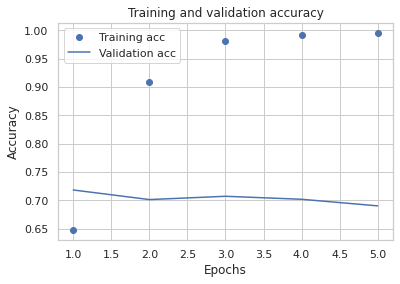

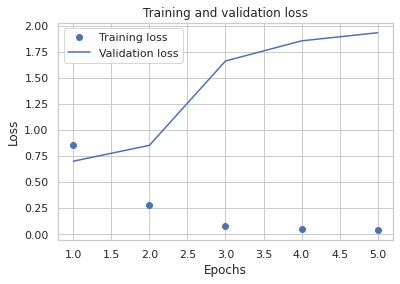

In [ ]:
acc=history.history['categorical_accuracy']
val_acc=history.history['val_categorical_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

pred = model.predict(X_val)
predict_classes = np.argmax(pred,axis=1)
expected_classes = np.argmax(y_val,axis=1)
correct = accuracy_score(expected_classes,predict_classes)
print(f"Accuracy: {correct}")

Accuracy: 0.6902748414376322


In [ ]:
from tensorflow.python.keras.models import load_model

best_model = load_model('MovieGenrePredictionUsingPlotSummariesmodel1.h5')

In [ ]:
batch_size=64
steps_test=int(len(X_val)/batch_size)
result = best_model.evaluate(X_val, y_val, steps=steps_test,verbose=1)
print("Validation-set accuracy: {0:.2%}".format(result[1]))

14/14 [==============================] - 3s 160ms/step - loss: 0.7008 - categorical_accuracy: 0.7183
Validation-set accuracy: 71.83%


In [ ]:
best_model.save('fypmodel{:.2%}.h5'.format(result[1]))
name='fypmodel{:.2%}.tflite'.format(result[1])
converter = tf.lite.TFLiteConverter.from_keras_model(best_model) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open(name, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpa3q20zqb/assets


INFO:tensorflow:Assets written to: /tmp/tmpa3q20zqb/assets


In [ ]:
preds = best_model.predict(X_val, batch_size=128,verbose=1)
preds=np.around(preds)

orig_val_labels=np.argmax(y_val,axis=1)
predicted_labels=np.argmax(preds,axis=1)

orig_val_labels=np.reshape(orig_val_labels,(len(X_val),1))
predicted_labels=np.reshape(predicted_labels,(len(X_val),1))

print(predicted_labels.shape)
print(orig_val_labels.shape)

15/15 [==============================] - 3s 142ms/step
(1892, 1)
(1892, 1)


<Figure size 432x288 with 0 Axes>

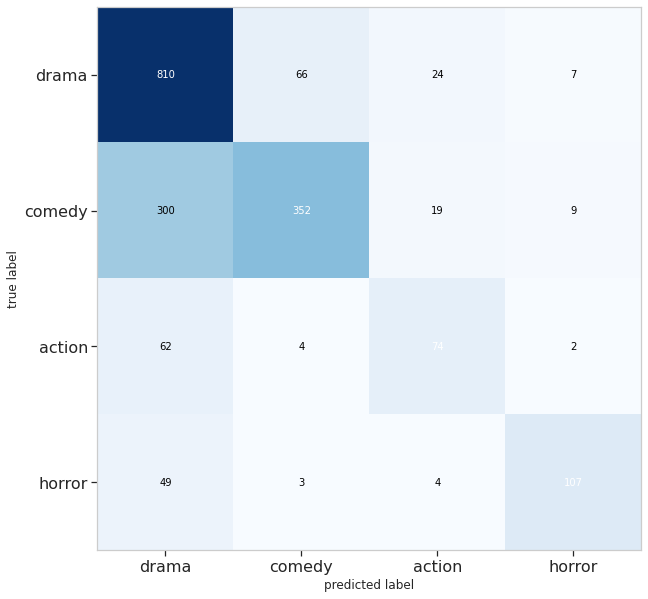

In [ ]:
%matplotlib inline
# Get the confusion matrix
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm  = confusion_matrix(orig_val_labels, predicted_labels)
plt.figure()
plot_confusion_matrix(cm,figsize=(15,10), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(4), ['drama','comedy','action','horror'], fontsize=16)
plt.yticks(range(4), ['drama','comedy','action','horror'], fontsize=16)
plt.show()

In [ ]:
# calculates precision for 1:100 dataset with 90 tp and 30 fp
from sklearn.metrics import precision_score
precision = precision_score(orig_val_labels,predicted_labels,average='micro')
print('Precision: %.3f' % precision)

Precision: 0.710


In [ ]:
print(classification_report(orig_val_labels,predicted_labels,target_names=MainGenres))

              precision    recall  f1-score   support

       drama       0.66      0.89      0.76       907
      comedy       0.83      0.52      0.64       680
      action       0.61      0.52      0.56       142
      horror       0.86      0.66      0.74       163

    accuracy                           0.71      1892
   macro avg       0.74      0.65      0.68      1892
weighted avg       0.74      0.71      0.70      1892

